# NBE-E4260 Genesis and Analysis of Brain Signals 2023
Matias Palva, Joonas Juvonen, Vladislav Myrov, Joona Repo, Merlin Dumeur

# Exercise D, deadline on Sunday 9.4.2022 23:59 PM

This exercise round builds upon the knowledge you have gained throughout the course and takes you through an end-to-end analysis of real brain data, acquired using magnetoencephalography (MEG). The process begins with various preprocessing steps, progresses through source modeling, and concludes with results that are derived through statistics. Although preprocessing is not the primary focus of the course, this exercise aims to provide a solid foundation that you can further develop in your own work.

Due to computational resource limitations and time constraints, some steps have been simplified; however, they should still offer a general understanding of what is required. To ensure that you do not encounter significant problems with RAM, we will save numerous intermediate results and periodically restart kernels. Please follow the instructions carefully!

In [1]:
# Need to only run once to install the required package
!pip install mne

     |████████████████████████████████| 7.6 MB 15.7 MB/s eta 0:00:01


In [4]:
# import the required libraries
import mne
import sys
import gc

import numpy as np

from mne.preprocessing import ICA
from ipywidgets import *

# Explicitly state that we are rendering figures in the interactive notebook format
%matplotlib notebook

## Load the data.

### Data consent

The data we're using in this exercise is real brain data and is considered highly sensitive. Students of NBE-E4260 Genesis and Analysis of Brain Signals 2023 are granted permission to use the provided MEG data and processed MRI data exclusively for this specific exercise (Exercise D). Distribution of the data or its use in any other process, publication, or project is strictly prohibited.

Alright! Now that we've covered the consent, let's dive in and have some fun!

The data we'll be using for this exercise was measured using magnetoencephalography (MEG), specifically the Megin TRIUX system. The dataset contains approximately 5 minutes of eyes-open resting state data with mild fixation from a single subject. The data is sampled at 1 kHz and includes 102 magnetometers and 204 gradiometers. First, let's load the data from the coursedata directory. Then, we'll crop the data to a shorter duration and downsample it significantly to reduce computational load.

Feel free to run the code provided below!

__Useful functions:__

- [`mne.io.read_raw_fif`](https://mne.tools/stable/generated/mne.io.read_raw_fif.html)

__Useful data properties:__

- `data.info` contains essential information about a recording (e.g., sampling frequency)




In [5]:
# Load the dataset, preload=True flag is required when doing any modifications to the data
raw = mne.io.read_raw_fif("/coursedata/rs_data/resting_state_raw.fif", preload=True) 
        
raw = raw.crop(0, 3*60)        # crop to preserve memory, specified in seconds
raw = raw.resample(250)        # downsample to preserve memory, new sfreq 250 Hz

Opening raw data file /coursedata/rs_data/resting_state_raw.fif...
    Read a total of 8 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 121000 ... 736999 =    121.000 ...   736.999 secs
Ready.
Reading 0 ... 615999  =      0.000 ...   615.999 secs...
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)


In [6]:
print(raw.info)

<Info | 23 non-empty values
 acq_pars: ACQactiveGround 0 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG003, MEG0111, MEG0112, MEG0113, MEG0121, MEG0122, ...
 chs: 2 EOG, 102 Magnetometers, 204 Gradiometers, 6 misc, 17 Stimulus, 1 SYST
 custom_ref_applied: False
 description: TRIUX system at Biomag
 dev_head_t: MEG device -> head transform
 dig: 120 items (3 Cardinal, 5 HPI, 112 Extra)
 experimenter: Jaana Simola (jasimola)
 file_id: 4 items (dict)
 gantry_angle: 60.0
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 125.0 Hz
 meas_date: 2020-12-04 09:32:24 UTC
 meas_id: 4 items (dict)
 nchan: 332
 proj_id: 1 item (ndarray)
 proj_name: anxiety
 projs: generated with autossp-1.0.1: off, generated with autossp-1.0.1: ...
 sfreq: 250.0 Hz
 subject_info: 6 items (dict)
>


## Task 0: Identifying Bad Channels

In a typical workflow, the first thing to do is to examine the raw data carefully. This crucial step should not be overlooked. As you repeatedly inspect raw time series data, your eyes will become adept at identifying abnormalities. Although time series plotting is somewhat inconvenient in JupyterHub, you can still get a good look at the data. Run the command below to generate an interactive figure for data inspection. You can navigate through the channels using arrow keys, scrolling, or the scroll bars (clicking the scroll bars with a mouse is usually the most reliable method).

As you examine the data, you'll notice one channel with very high and spiky fluctuations compared to other channels. Mark this as bad by clicking on it (it will become semi-transparent). Additionally, there's a channel that appears quite flat; you can mark this as bad as well.

Apart from bad channels, it's common for the first and/or last seconds of the data to contain strong artifacts resulting from starting or stopping data acquisition. In our case, we've already cropped the data after loading, so this isn't an issue. It's also helpful to visually confirm the presence of blinks, heartbeat, and other artifacts – we'll remove these later on.

Take your time to inspect the data thoroughly! Eyeballing raw data is an essential skill for a neuroscientist.

__!! Important !!__

When you're done inspecting the data, click the on/off-like button in the top-right corner of the plot. This ensures that the selected bad channels are preserved in the `raw` object!

Additionally, you can store the bad channel names (e.g., 'MEGXXXX') in the list provided a bit further down in the notebook if you need to rerun it.


Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


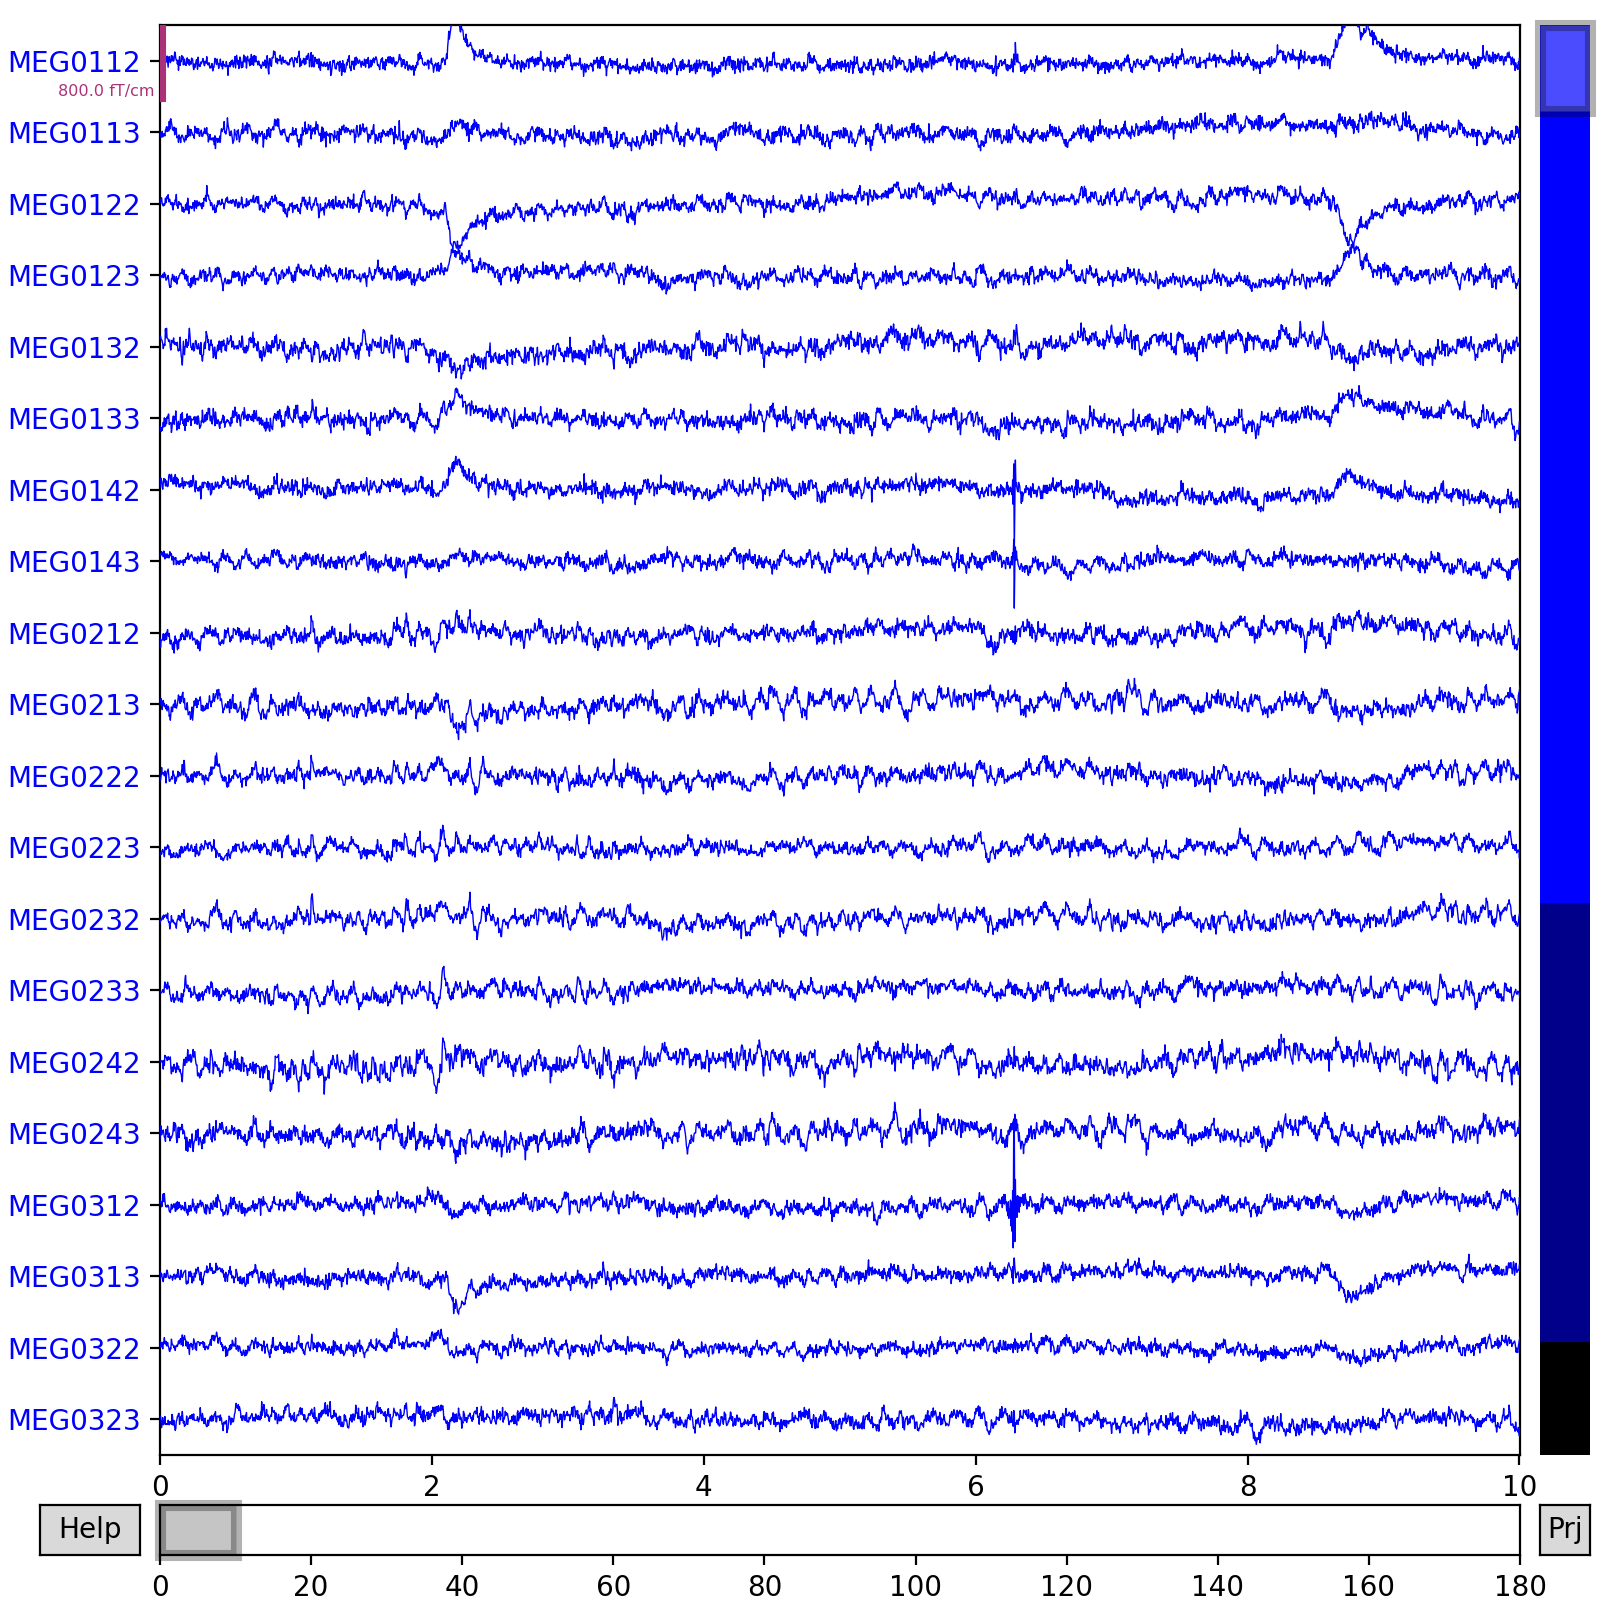

In [7]:
raw.plot();  # let's plot the raw data, the ';' makes sure only one interactive figure is shown

In [8]:
# you can also manually store your bad channels like this (in case you need to rerun the notebook)
#raw.info['bads'] = ['MEG1112', 'MEG0533'] #['list', 'channels', 'here']
# where MEG1112 is the flat channel and MEG0533 is the spiky one.
raw.info['bads'] = ['MEG1112', 'MEG0533'] 

In [9]:
# You can verify here that you indeed have a bad channel marked as bad
print(raw.info['bads'])

['MEG1112', 'MEG0533']


## Task 1: Temporal Signal Space Separation (tSSS)

tSSS, also known as Maxfiltering, is a MEG-specific method used to suppress extracranial noise from the recording. While the technique involves a considerable amount of mathematics and operational principles, we won't delve into the details here. From a user's perspective, the process is quite straightforward, and we can utilize an MNE function for this task. Maxfilter not only suppresses extra-cranial noise but also offers additional functionalities such as bad channel interpolation (hence why we marked the bad channels earlier), motion correction, and more.

Fun fact: The entire method was invented at TKK (Helsinki University of Technology), which later became Aalto University.

_For those interested in learning more, check out these links:_

- [MNE tSSS tutorial](https://mne.tools/dev/auto_tutorials/preprocessing/60_maxwell_filtering_sss.html)
- [PubMed article on Maxfiltering](https://pubmed.ncbi.nlm.nih.gov/16552102/)

### Review the Power Spectrum of the Data

Before we proceed with tSSS, let's first examine the power spectrum of the data! Your initial task is to compute and display the power spectral density (PSD) for the recording. The data we loaded is an MNE `Raw` object with several useful methods available. Check the links below for reference:

_Useful links:_

- [`mne.io.Raw` documentation](https://mne.tools/stable/generated/mne.io.Raw.html)
- [`mne.io.Raw.plot_psd` method](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.plot_psd)

_Useful notes:_

- To use methods for any Python object, call them like this: `object_name.method_name(parameters_here)`
- Use the `Raw` object's `plot_psd` method with the provided frequencies. This plot is also interactive if you'd like to explore the PSD further.
- To avoid rendering both a static image and an interactive plot, append a semicolon (`;`) at the end of the plotting command (without quotes).
- If you encounter an error related to channel MEG1112, add it to the list of bad channels to render the gradiometer PSD correctly.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


<IPython.core.display.Javascript object>


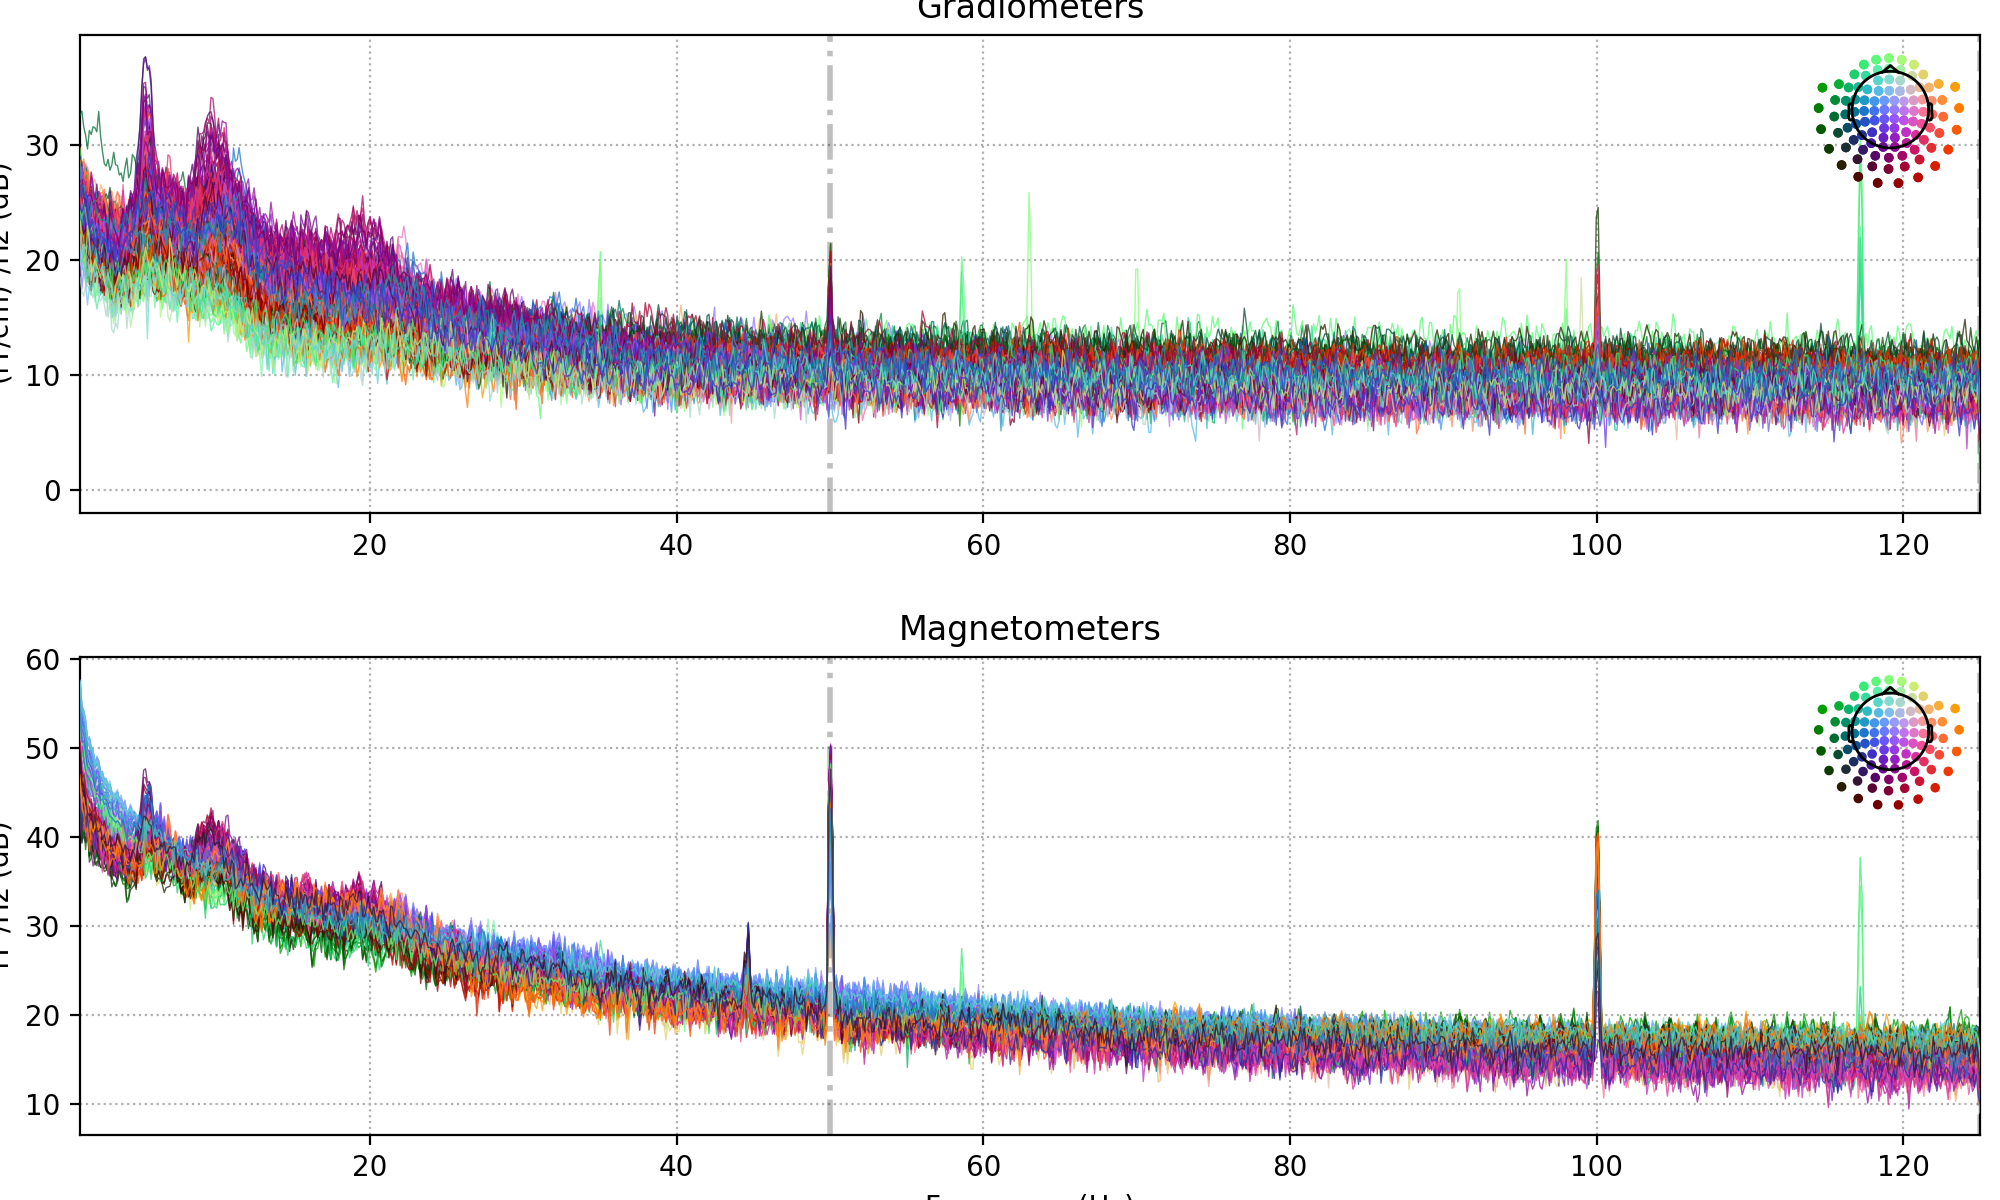

In [10]:
fmin = 1
fmax = 125 # 125Hz is the Nyquist frequency (= sfreq / 2)

# YOUR PSD CODE HERE
psd = raw.plot_psd(fmin = fmin, fmax = fmax);

You should have obtained a figure with magnetometers and gradiometers. The signal quality is quite good, and there are several high-power peaks. However, line harmonics are clearly present in the data. Next, we will apply the Maxfilter function to eliminate some extracranial noise. Use the given parameters.

__Useful links:__

- [MNE Maxfilter documentation](https://mne.tools/stable/generated/mne.preprocessing.maxwell_filter.html)


In [11]:
# MEG can have this fool proof coil naming that causes an error
# with some functions. This naming can be fixed by calling the
# function below
raw.fix_mag_coil_types()

st_duration = 10            # duration of the temporal window, 10 seconds is pretty good. More requires more RAM
st_correlation = 0.9        # pretty typical correlation used

# YOUR CODE HERE
maxwell_filter = mne.preprocessing.maxwell_filter(raw, st_duration = st_duration, st_correlation = st_correlation)

102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG1112', 'MEG0533']
    Processing 204 gradiometers and 102 magnetometers
    Automatic origin fit: head of radius 91.7 mm
    Using origin 1.5, 10.1, 43.6 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Using loaded raw data
    Processing 18 data chunks
        Projecting  6 intersecting tSSS components for    0.000 -    9.996 sec  (#1/18)
        Projecting  4 intersecting tSSS components for   10.000 -   19.996 sec  (#2/18)
        Projecting  3 intersecting tSSS components for   20.000 -   29.996 sec  (#3/18)
        Projecting  3 intersecting tSSS components for   30.000 -   39.996 sec  (#4/18)
        Projecting  4 intersecting tSSS components for   40.000 -   49.996 sec  (#5/18)
        Projecting  4 intersecting tSSS components for   50.000 -   59.996 sec

Great job! Now, let's examine the PSD once again to see the results of the Maxfiltering.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


<IPython.core.display.Javascript object>


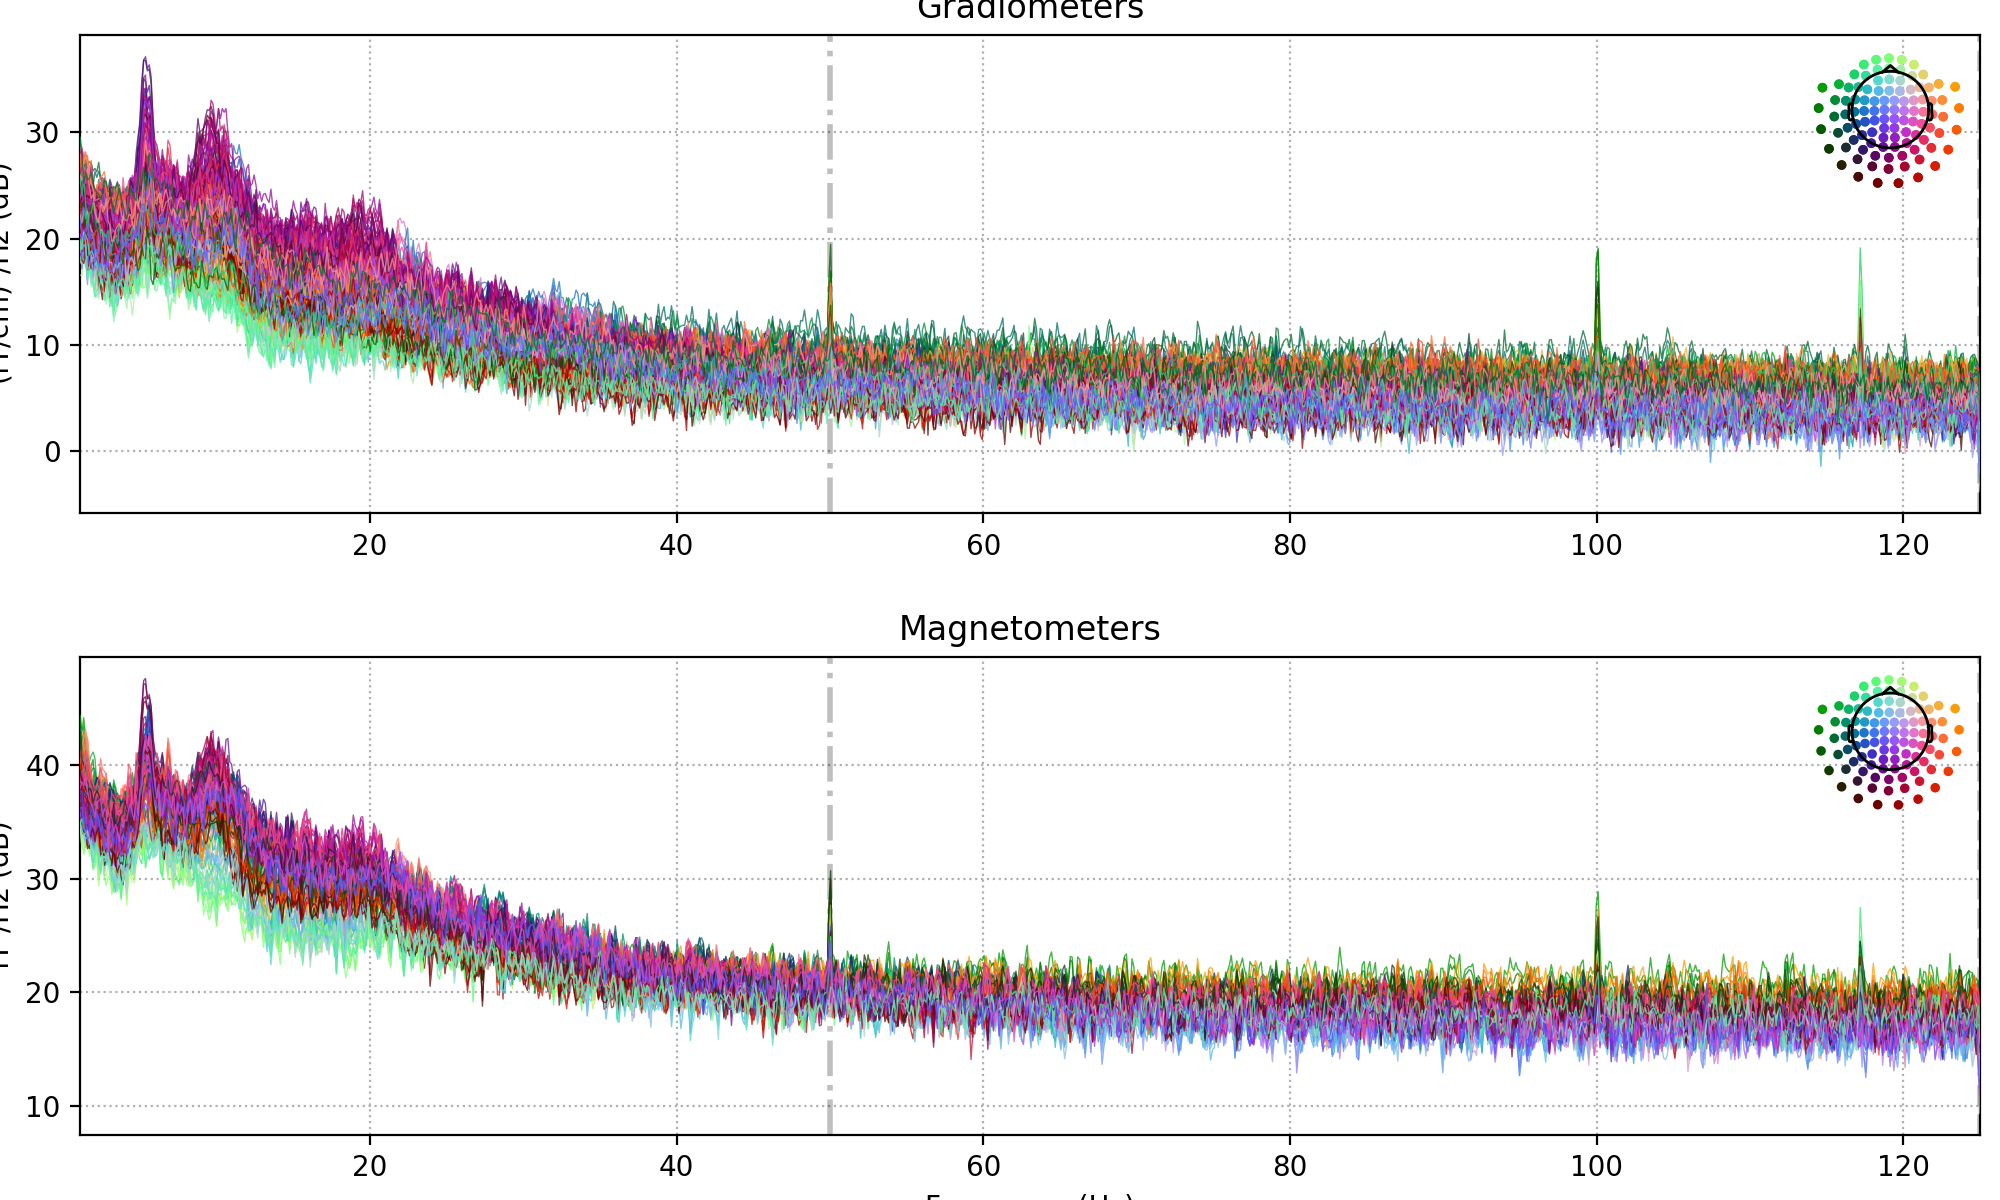

In [12]:
fmin = 1
fmax = 125

# YOUR CODE HERE
new_psd = maxwell_filter.plot_psd(fmin = fmin, fmax = fmax);

The improvements in data quality after Maxfiltering are immediately noticeable, right? Nonetheless, line harmonic peaks (50Hz + multiples of 50Hz) still need to be removed.

Your next task is to use a Notch filter, which is a special type of narrow band block filter typically employed for eliminating line interference and harmonics. The MNE `Raw` object has a convenient method for this.

All you need to define are the center frequencies. MNE's automatically designed filter is generally sufficient. Select the center frequencies to remove the line interference and harmonics from the signal in the plotting range above (1-125Hz). You can input the frequencies as a list or an array.

__Useful links:__

- [MNE Raw.notch_filter documentation](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.notch_filter)
- [NumPy arange function](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)


In [13]:
# YOUR CODE HERE
center_freqs = np.arange(50, 150, 50)
notch_filter = raw.notch_filter(freqs = center_freqs)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    1.1s finished


With the harmonics removed, there's still one crucial filtering step to perform before the independent component analysis (ICA). ICA is highly sensitive to low-frequency drifts, so it's strongly recommended to apply a high-pass filter (typically 1Hz) to the data beforehand. Consider why slow-frequency drifts might hinder ICA performance.

The `Raw` object also has a filter method for this purpose. For this task, just set the frequencies as provided below. A 1 Hz high-pass filter ensures the proper functioning of ICA. Since we resampled the data earlier, it is already adequately low-pass filtered at the Nyquist frequency. MNE automatically designs a suitably good, zero-phase filter that works well in most cases.

__Useful links:__

- [MNE Raw.filter documentation](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter)

__Important note about filters:__

All filters induce phase shifts and/or distortions. Some methods can compensate for this shift, and zero-phase filters have a native way of addressing it. Imagine you are computing a synchronization metric, and your phase is shifted due to filtering – this can adversely affect your temporal localization!

In [14]:
l_freq = 1
h_freq = None

# YOUR CODE HERE
hp_filter = raw.filter(l_freq = l_freq, h_freq = h_freq)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.8s finished


Let's plot the PSD once more to see the improvements!

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


<IPython.core.display.Javascript object>


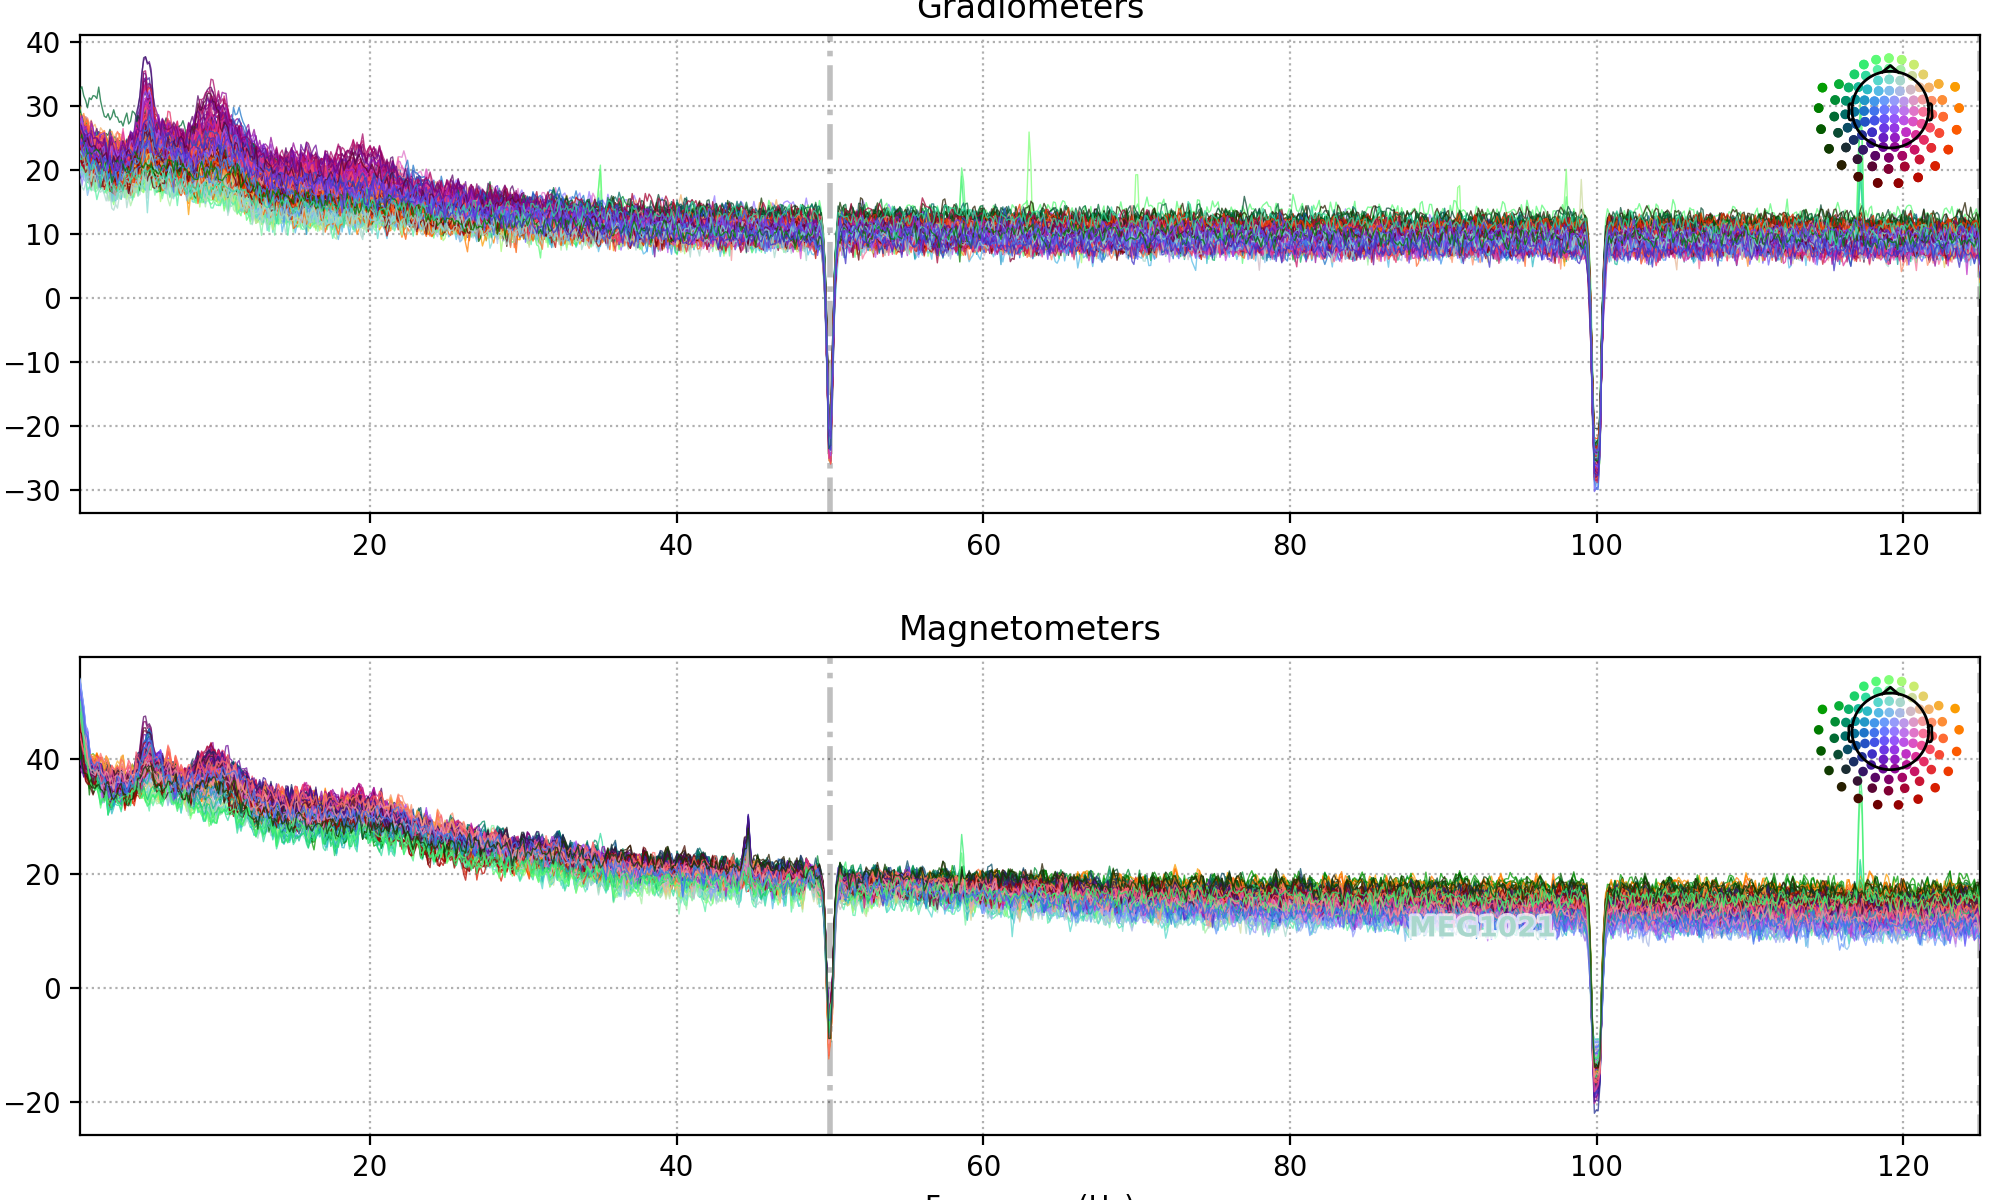

In [15]:
fmin = 1
fmax = 125

# YOUR PSD AGAIN HERE
final_psd = hp_filter.plot_psd(fmin = fmin, fmax = fmax);

Having completed the initial automatic processing steps, our signal quality has significantly improved. Nonetheless, a discerning eye can still identify some lingering physiological artifacts. This is where manual intervention comes into play.

## Task 2. Independent Component Analysis (ICA)

ICA is a powerful blind source separation technique with numerous engineering applications, including neuroscience, signal processing, and telecommunications. There are various ways to perform ICA and multiple methods to choose from, such as FastICA, Infomax, and SOBI, making it one of the most challenging and time-consuming tasks for a neuroscientist. Identifying artifactual components in real brain data is prone to bias, so it's crucial to proceed with caution. When in doubt, consult your colleagues for their opinions.

For our data, we'll apply ICA cleaning to remove clear artifactual components such as heartbeat, blinks, and other non-brain-related signals. ICA works by separating distinct components from the signal, which can be removed before recombining the components into a time-series.

Ideally, ~70 components should be used, depending on the data's characteristics and rank. However, in this task, we'll only use 20 components to reduce computational load. We've chosen the default FastICA method for this purpose.

Begin by setting up the ICA with the given parameters, and then fit it to the raw data.

__Useful links__

- [MNE ICA Documentation](https://mne.tools/stable/generated/mne.preprocessing.ICA.html)
- [FastICA Algorithm](https://en.wikipedia.org/wiki/FastICA)


In [17]:
# parameters for the ica initiation
n_components = 20
method = 'fastica'
random_state = 50 # let's lock the random state to have comparable results between runs

# YOUR CODE HERE
ica = ICA(n_components = n_components, method = method, random_state = random_state).fit(raw)

Fitting ICA to data using 304 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.7s.


### Inspecting ICA components

Now, let's inspect the ICA components. The ICA object has a method called `plot_sources`, which we'll use to visualize the timeseries of ICA components. Although the resolution of the figure could be better, this will suffice for practice. Your task is to identify and remove all components that are clearly artifactual (e.g., flat, thick line of buzzy noise, heartbeat, blinks) by clicking the corresponding component timeseries (which will turn grey).

In the second code box, you can plot properties of ICA components! This is very useful, as it provides information about localization, distributions, spectrum, and more. Use this tool to find the bad components. A good rule of thumb is that a valid neural signal is relatively stable, shows a dipole-like distribution, and has a meaningful spectrum (e.g., alpha, theta). Don't hesitate to ask for assistance if needed.

Take note of the bad components and write their indices in the `bads` list (they will remain consistent between runs due to the locked random state). Generally, our goal is to remove all artifacts while retaining as much data as possible. Remember to click the on/off-like button in the top-right corner when you are done with the interactive plot.

While this mandatory part of signal cleaning isn't the main focus of the course, it serves as a valuable introduction to this broad topic. For a very good learning resource to practice identifying different components, check out the UCSD website.

__Useful links__

- [MNE ICA Documentation: plot_sources](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_sources)
- [ICA Component Identification Tutorial](https://labeling.ucsd.edu/tutorial/about)


Creating RawArray with float64 data, n_channels=22, n_times=45000
    Range : 30250 ... 75249 =    121.000 ...   300.996 secs
Ready.


<IPython.core.display.Javascript object>


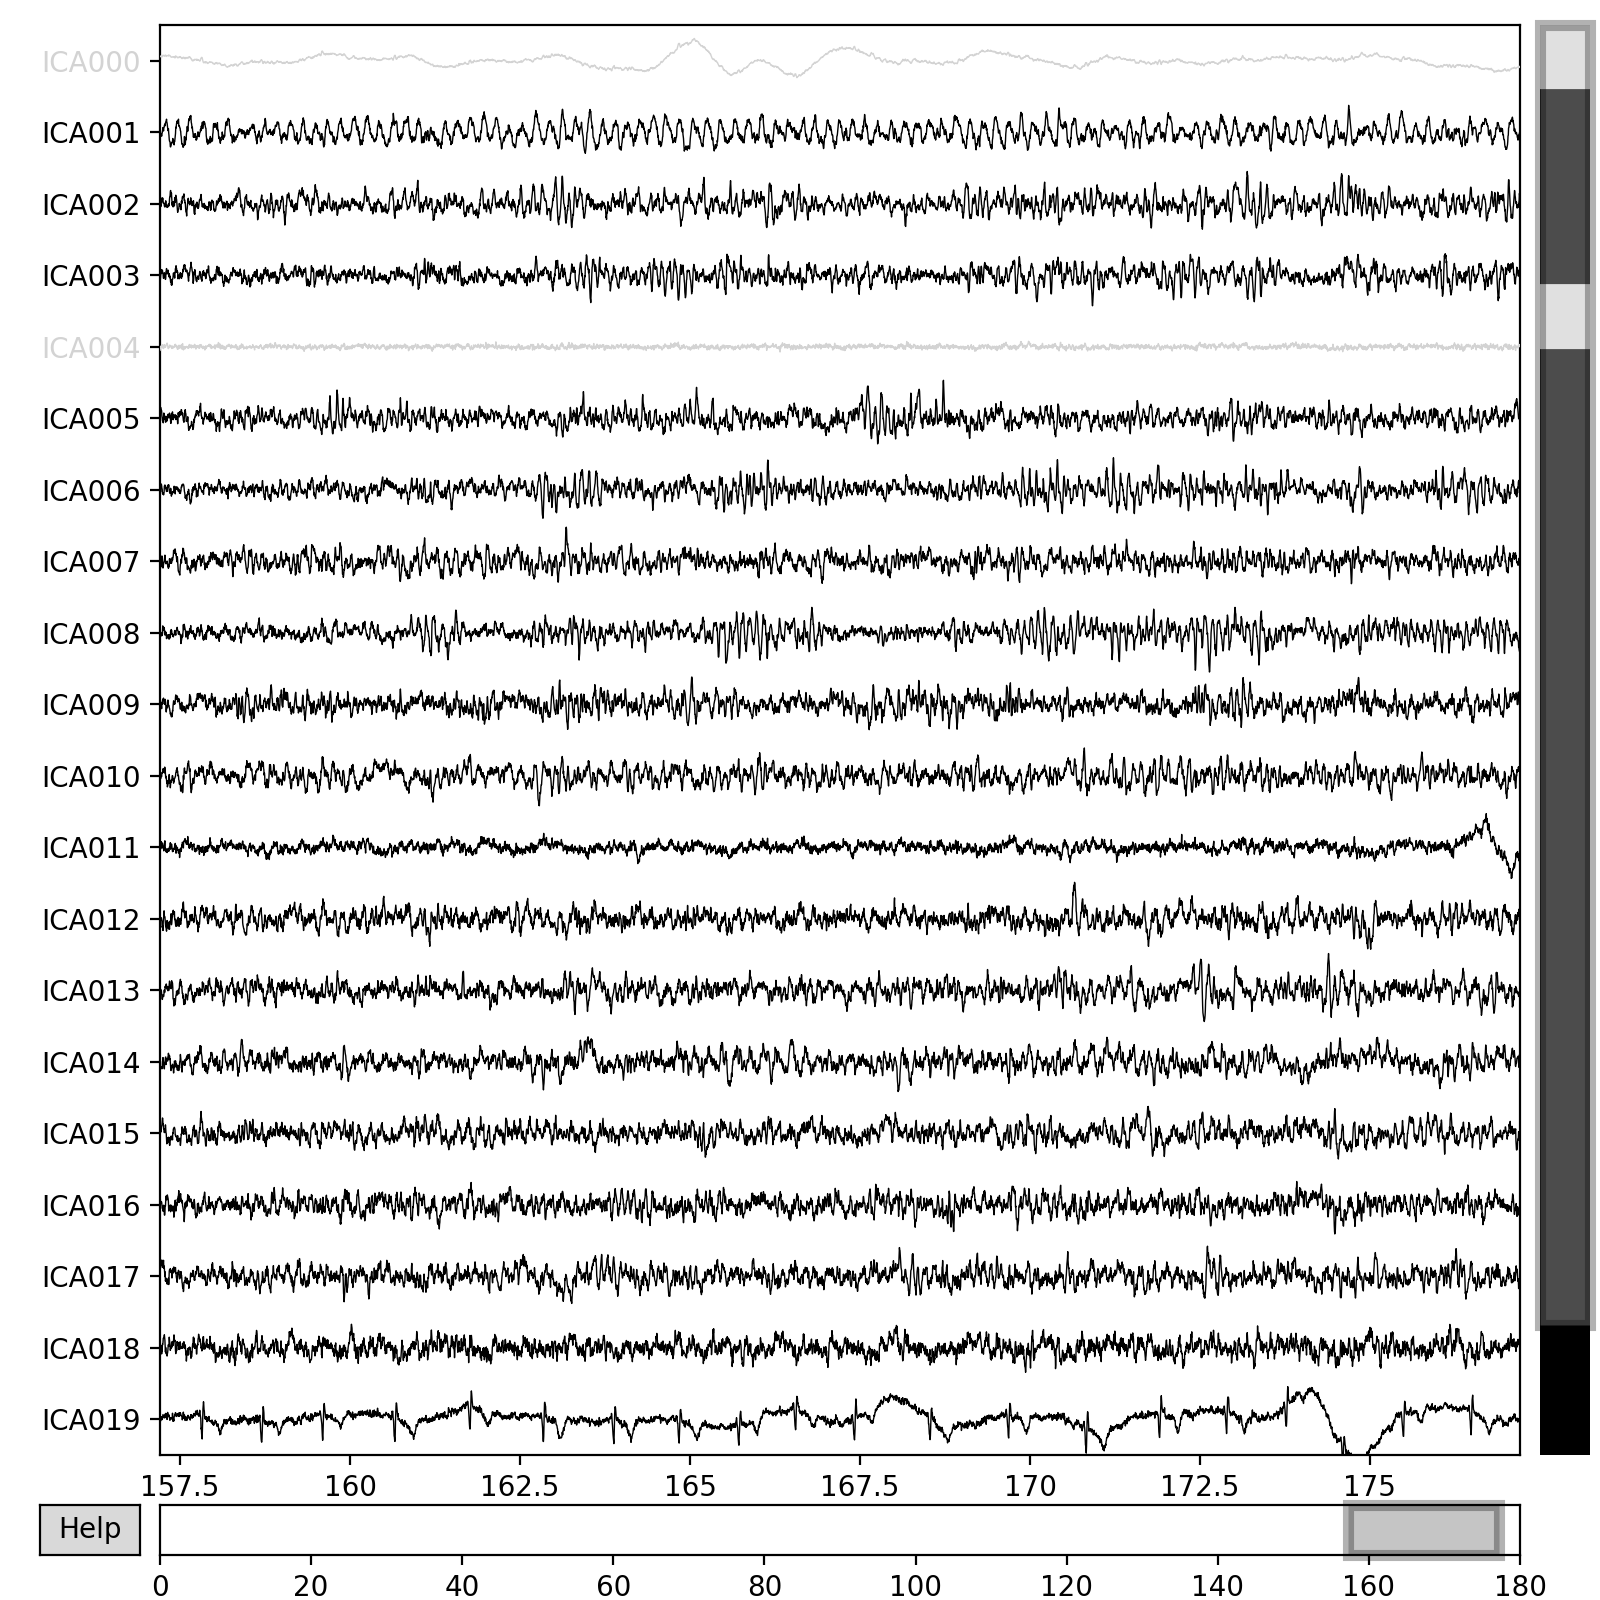

In [20]:
# Plot component timeseries
ica.plot_sources(raw);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated


<IPython.core.display.Javascript object>


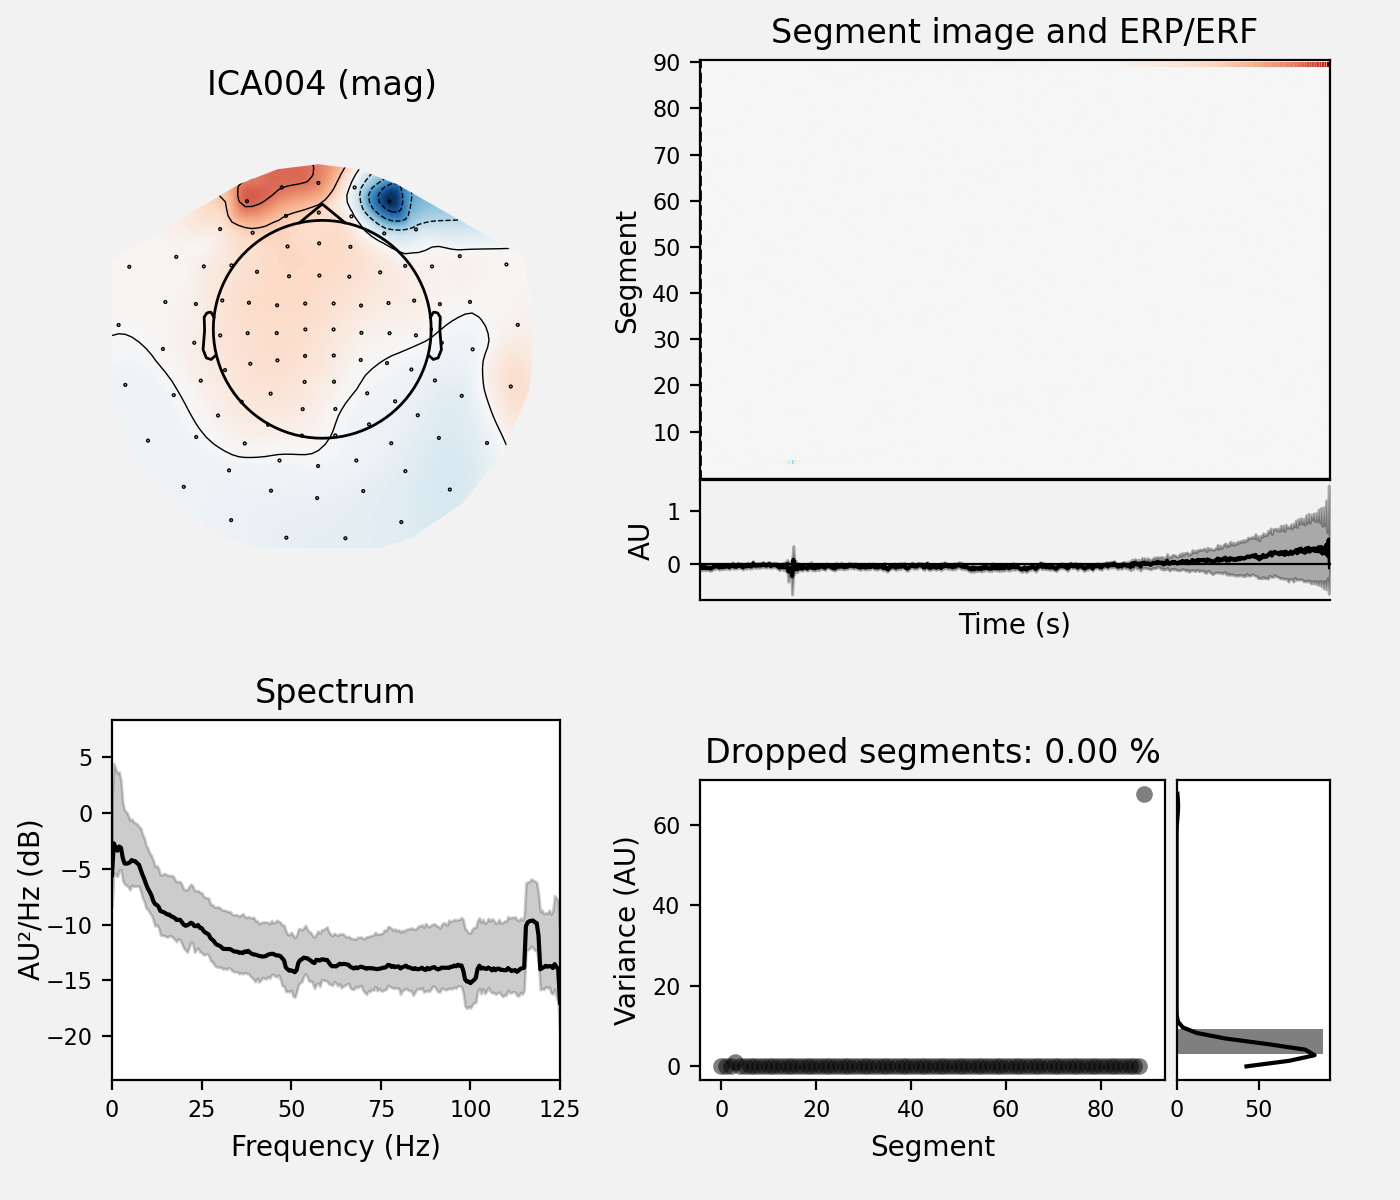

[<Figure size 700x600 with 6 Axes>]

In [24]:
# plot component properties
ica.plot_properties(raw, picks=4) 

#NOTE: the picks= here means the index of the component
# plot the component you want to see one by one (jupyterhub might crash from too many figures)

For convenience, list the bad components here in case you need to rerun the notebook:

In [26]:
bads = ['ICA000', 'ICA004']                       # collect the indices of bad components here, starting from zero
                                # this will also ensure that you don't need to go and select them again
                                # if you need to run the notebook again

We can now reconstruct the cleaned signal based on the components we've kept. The components will be mixed again, leaving out the bad ones.

In [27]:
# Set the to-be-removed components explicitly again from the collected bads-list
ica.exclude = bads.copy()

# Apply the mixing matrix
raw_cleaned = ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 304 PCA components


/opt/software/lib/python3.9/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


As the next part of the notebook can be computationally intensive, it's a good idea to save your results now. Once you've saved them, restart your kernel to ensure you don't have any unnecessary elements in your RAM.

In [28]:
raw_cleaned.save("resting_state_cleaned_raw.fif")

Writing /notebooks/gabs2023/Exercise D/resting_state_cleaned_raw.fif
Closing /notebooks/gabs2023/Exercise D/resting_state_cleaned_raw.fif
[done]


# ! Restart your kernel before proceeding further !

## Task 3. Source Modeling

In this task, we will perform source modeling on the obtained data based on individual cortical anatomy, allowing us to go from sensor data to parcel-level information. Preprocessed MRI files, created with FreeSurfer, have been provided for this purpose. FreeSurfer is a software package used for volumetric segmentation (e.g., skull, skin, white matter) and parcellation according to a chosen parcellation scheme. Here, we have selected the Schaefer 100-parcel parcellation scheme, which is based on the Yeo-17 networks.

First, let's load the necessary packages and the cleaned time-series data from the previous task.

__Schaefer and Yeo Parcellation Articles__

- [Multimodal Driven Cortical Parcellation: An Application of the Schaefer Parcellation to the HCP Dataset](https://pubmed.ncbi.nlm.nih.gov/28981612/)
- [The Organization of the Human Cerebral Cortex Estimated By Intrinsic Functional Connectivity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3174820/)


In [2]:
# import the required libraries again
import mne
import sys
import gc

import numpy as np
import matplotlib.pyplot as plt

from mne.preprocessing import ICA
from tqdm.notebook import tqdm
from scipy import signal
from ipywidgets import *


%matplotlib notebook

In [3]:
# Load your cleaned data
raw = mne.io.read_raw_fif("resting_state_cleaned_raw.fif", preload=True)

Opening raw data file resting_state_cleaned_raw.fif...
    Read a total of 8 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 30250 ... 75249 =    121.000 ...   300.996 secs
Ready.
Reading 0 ... 44999  =      0.000 ...   179.996 secs...


### Setting Up the Source Space and BEM Model

First, we'll set up a source space and create a BEM (Boundary Element Method) model and solution. Computing the source space may take a couple of minutes. To reduce computation time, we'll use a sparser spacing. These only need to be created once and can then be saved and loaded for future use.

__Useful links__:

- [mne.setup_source_space](https://mne.tools/stable/generated/mne.setup_source_space.html)
- [mne.make_bem_model](https://www.google.com/search?client=firefox-b-d&q=mne+make+bem+model)
- [mne.make_bem_solution](https://mne.tools/stable/generated/mne.make_bem_solution.html)


In [4]:
# define some required things
subject = r"/coursedata/rs_data"
mne.utils.set_config("SUBJECTS_DIR", r'/coursedata/rs_data/', set_env=True)

spacing = 10                # a bit more sparse spacing to again save computational time
                            # in real life you want to use 7 or ideally maybe 5
    
conductivity = [0.3]        # one layer enough for MEG


# YOUR CODE HERE
src = mne.setup_source_space(subject = subject, spacing = spacing)
model = mne.make_bem_model(subject = subject, conductivity = conductivity)
bem = mne.make_bem_solution(surfs = model)


# In the end, save the BEM
mne.write_source_spaces("src.fif", src, overwrite=True)
mne.write_bem_solution("bem.fif", bem, overwrite=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /coursedata/rs_data
Subject      = /coursedata/rs_data
Surface      = white
Approximate spacing 10 mm

>>> 1. Creating the source space...

Loading /coursedata/rs_data/surf/lh.white...
Mapping lh /coursedata/rs_data -> spacing (10) ...
    Triangle neighbors and vertex normals...
    Vertex neighbors...
    Decimating...
loaded lh.white 2180/168608 selected to source space (spacing = 10)

Loading /coursedata/rs_data/surf/rh.white...
Mapping rh /coursedata/rs_data -> spacing (10) ...
    Triangle neighbors and vertex normals...
    Vertex neighbors...
    Decimating...
loaded rh.white 2234/170212 selected to source space (spacing = 10)

Calculating source space distances (limit=inf mm)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished


    Computing patch statistics...
    Patch information added...
    Computing patch statistics...
    Patch information added...
You are now one step closer to computing the gain matrix
Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -3.57 -32.72  29.07 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...


/tmp/ipykernel_172/1757535425.py:18: RuntimeWarning: This filename (src.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif or _src.fif.gz
  mne.write_source_spaces("src.fif", src, overwrite=True)


    [done]
    2 source spaces written
Overwriting existing file.


### Creating the Forward Solution

Now we have the required files to create the forward solution, which essentially shows the distribution of electrical currents generated by N dipoles placed within the brain. We'll need the `info`, `cor`, `src`, and `bem` files for this step. Set the MEG flag to `True` and EEG to `False`. This process should take no more than a few seconds.

__Useful links__:

- [mne.make_forward_solution](https://mne.tools/stable/generated/mne.make_forward_solution.html)


In [5]:
info = raw.info.copy()
cor = "/coursedata/rs_data/trans.fif"
bem = mne.read_bem_solution("bem.fif")
src = mne.read_source_spaces("src.fif")

# YOUR CODE HERE
fwd = mne.make_forward_solution(info = info, trans = cor, src = src, bem = bem, meg = True, eeg = False)


# Save it
mne.write_forward_solution("fwd.fif", fwd, overwrite=True)

Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear collocation BEM solution from /notebooks/gabs2023/Exercise D/bem.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...


/tmp/ipykernel_172/2717039423.py:4: RuntimeWarning: This filename (/notebooks/gabs2023/Exercise D/src.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces("src.fif")


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Source space          : <SourceSpaces: [<surface (lh), n_vertices=168608, n_used=2180>, <surface (rh), n_vertices=170212, n_used=2234>] MRI (surface RAS) coords, subject '/coursedata/rs_data', ~28.9 MB>
MRI -> head transform : /coursedata/rs_data/trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 4414 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.997701  0.017398  0.065503       2.97 mm
    -0.042104  0.916472  0.397878      23.49 mm
    -0.053110 -0.399721  0.915097      14.17 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
105 coil definitio

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/1483 points outside using solid angles
    Total 2180/2180 points inside the surface
Interior check completed in 1529.2 ms
Checking surface interior status for 2234 points...
    Found  651/2234 points inside  an interior sphere of radius   53.7 mm
    Found    0/2234 points outside an exterior sphere of radius  104.6 mm
    Found    0/1583 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/1583 points outside using solid angles
    Total 2234/2234 points inside the surface
Interior check completed in 1657.2 ms

Checking surface interior status for 306 points...
    Found   0/306 points inside  an interior sphere of radius   53.7 mm
    Found 306/306 points outside an exterior sphere of radius  104.6 mm
    Found   0/  0 points outside using surface Qhull
    Found   0/  0 points outside using solid angles
    Total 0/306 points inside the surface
Interior check completed in 31.7 ms

Composing the field computation matrix...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0

Computing MEG at 4414 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



Finished.
Overwriting existing file.
    Write a source space...


/tmp/ipykernel_172/2717039423.py:11: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution("fwd.fif", fwd, overwrite=True)


    [done]
    Write a source space...
    [done]
    2 source spaces written


### Creating the Inverse Solution

The next step is to create the inverse solution. Given the observed electrical activity on the sensors and their locations, we want to estimate the origins of the activity. This is an ill-posed problem, but it can be estimated with proper regularization.

An important aspect of source modeling is the noise covariance matrix (NCM). This estimates the scale and correlation of noise in the recording. MNE has a function for this:

__Useful links__:

- [mne.compute_raw_covariance](https://mne.tools/stable/generated/mne.compute_raw_covariance.html)

For continuous recordings (such as resting state), this method works well. For event-related data, we typically select the NCM window to be somewhere before stimulus onset, depending on the research question. There are multiple ways to choose the frequency band for computing the NCM, but we'll use the full signal band here (1-125Hz). Note that the choice of NCM can potentially inhibit observed brain activity. We'll use the default empirical method for computing the NCM.


In [10]:
# YOUR CODE HERE
cov = mne.compute_raw_covariance(raw = raw)

# Save the NCM
mne.write_cov("cov.fif", cov)

Using up to 900 segments
Number of samples used : 45000
[done]


/tmp/ipykernel_153/2339205080.py:5: RuntimeWarning: This filename (cov.fif) does not conform to MNE naming conventions. All covariance files should end with -cov.fif, -cov.fif.gz, _cov.fif or _cov.fif.gz
  mne.write_cov("cov.fif", cov)


### Obtaining Source Time-series

With the NCM, we can now create the inverse solution and apply it to the data to obtain the source time-series.

__Useful links__:

- [mne.minimum_norm.make_inverse_operator](https://mne.tools/stable/generated/mne.minimum_norm.make_inverse_operator.html)
- [mne.minimum_norm.apply_inverse_raw](https://mne.tools/stable/generated/mne.minimum_norm.apply_inverse_raw.html)

In [7]:
lambda2 = 1./9                              # Regularization term
inv_method = 'dSPM'                         # Noise normalization method
info = raw.info.copy()                      # We need the info for things like sfreq, digitization, etc.

# Load some files
fwd = mne.read_forward_solution("fwd.fif")
ncm  = mne.read_cov("cov.fif")

# YOUR CODE HERE
inv = mne.minimum_norm.make_inverse_operator(info = info, forward = fwd, noise_cov = ncm)
source_ts = mne.minimum_norm.apply_inverse_raw(raw = raw, inverse_operator = inv, lambda2 = lambda2, 
                                               method = inv_method)

Reading forward solution from /notebooks/gabs2023/Exercise D/fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...


/tmp/ipykernel_172/2039625698.py:6: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("fwd.fif")


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (4414 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    304 x 304 full covariance (kind = 1) found.
    Read a total of 8 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
Converting forward solution to surface orientation
    Average patch normals

/tmp/ipykernel_172/2039625698.py:7: RuntimeWarning: This filename (cov.fif) does not conform to MNE naming conventions. All covariance files should end with -cov.fif, -cov.fif.gz, _cov.fif or _cov.fif.gz
  ncm  = mne.read_cov("cov.fif")


    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 304 channels.
    304 out of 306 channels remain after picking
Selected 304 channels
Creating the depth weighting matrix...
    202 planar channels
    limit = 4118/4414 = 10.019511
    scale = 7.20502e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 8)
Computing rank from covariance with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 304 dim * 8  max singular value)
    Estimated rank (mag + grad): 296
    MEG: rank 296 computed from 304 data channels with 8 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.48376
    scaling factor to adjust the trace = 4.26923e+18 (nch

### Extract parcel timeseries

Finally, we need to extract the anatomical parcel time series from the source time series. Refer to the documentation on how to set the parameters for the function. While this tutorial provides an introduction to source modeling, a full 5-credit course on the topic is available at Aalto for those interested.

__Useful links__:

- [mne.extract_label_time_course](https://mne.tools/stable/generated/mne.extract_label_time_course.html)

In [8]:
labels = mne.read_labels_from_annot(r"/coursedata/rs_data", "parc2018yeo17_100")
labels_parc = []
label_names = [] # let's have these also separately if wanna look at the network names

# remove medial wall and such from the labels
for label in labels:
    if "Networks" in label.name:
        labels_parc.append(label)
        label_names.append(label.name)


# YOUR CODE HERE
parcel_ts = mne.extract_label_time_course(stcs = source_ts, labels = labels_parc, src = src)

Reading labels from parcellation...
   read 51 labels from /coursedata/rs_data/label/lh.parc2018yeo17_100.annot
   read 51 labels from /coursedata/rs_data/label/rh.parc2018yeo17_100.annot
Extracting time courses for 100 labels (mode: mean_flip)


Check the shape of our new source-modeled data! We will also remove some extra dimensions here. Now the shape of your data should be (n_parcels, n_samples).

In [9]:
parcel_ts = np.array(parcel_ts).squeeze() # some extra dimension out of the way
parcel_ts.shape # parcels, samples

(100, 45000)

Congratulations! You now have source-modeled parcel time series. Keep in mind that this procedure has been a simplified version, and there are many ways to enhance it (outside the scope of this course). Save the results to easily access them later if you need to restart for any reason.

In [10]:
# Save the timeseries!
np.save("parcel_ts.npy", parcel_ts)

# Now might be a good idea to again restart your kernel

## Task 4. Synchronization analysis

Let's start by loading our newly generated parcel timeseries and some necessary libraries.

In the next step, your task is to calculate iPLV and PLV for the given frequency and plot the results side-by-side. First, create an analytical signal from the parcel time series (parcel_ts) using wavelet transform. Below is a link to a MNE function that can do this for you. Otherwise, use the given parameters.

__Useful links__:

- [mne.time_frequency.tfr_array_morlet](https://mne.tools/stable/generated/mne.time_frequency.tfr_array_morlet.html)

After computing the complex PLV, create a subplot to display the imaginary phase-locking value (iPLV) in one panel and the PLV in another panel. Ensure that you include informative axis labels and colorbars for each plot, following standard conventions.

To accomplish this, you will need to iterate through all the parcels and apply a filter to each of them individually.

In [1]:
# import the required libraries again
import mne
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy import signal, stats
from ipywidgets import *


#%matplotlib notebook  # no need for this in here as our images are static

In [2]:
# Load the parcel timeseries
parcel_ts = np.load("parcel_ts.npy")

### Single frequency iPLV and PLV

In the next step, your task is to calculate iPLV and PLV for the given frequencies, and then visualize the results side-by-side for the ~10 Hz frequency (array index 6). To begin, create an analytical signal from the parcel time series (parcel_ts) using wavelet transform. You can use the `cwt` function from SciPy, or alternatively, use the MNE function linked below. The MNE function is considerably neater and it takes an array of shape (n_epochs, n_channels, n_times). In here we have only a 2D signal (n_parcels, n_times) so use it in the function as `[parcel_ts]` to add an extra dimension. Whether you use the MNE function or something else, use the provided parameters in either case.


In [3]:
w = 7
freqs = np.geomspace(1, 30, 10)
sampling_rate = 250

# YOUR CODE HERE
parcel_ts = np.array([parcel_ts])
print(parcel_ts.shape)
analytical_signal = mne.time_frequency.tfr_array_morlet(epoch_data = parcel_ts , sfreq = sampling_rate,
                                                       freqs = freqs)
print(analytical_signal.shape)

plv_mat = np.zeros((analytical_signal.shape[1],analytical_signal.shape[1]))
iplv_mat = np.zeros((analytical_signal.shape[1],analytical_signal.shape[1]))
for i in range(analytical_signal.shape[1]):
    for j in range(i + 1, analytical_signal.shape[1]):
        d_theta = np.angle(analytical_signal[0, i] / analytical_signal[0, j])
        plv = np.abs(np.mean(np.exp(1j * d_theta)))
        iplv = np.abs(np.mean(np.exp(1j * d_theta)).imag)
        plv_mat[i, j] = plv
        plv_mat[j, i] = plv
        iplv_mat[i, j] = iplv
        iplv_mat[j, i] = iplv

(1, 100, 45000)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


(1, 100, 10, 45000)


In [4]:
print(plv_mat.shape)
print(iplv_mat.shape)

(100, 100)
(100, 100)


Once you have computed the complex PLV, create a subplot that displays the imaginary phase-locking value (iPLV) in one panel and the PLV in another panel for the ~10 Hz data. Ensure that you include informative axis labels and colorbars for each plot, adhering to standard conventions.

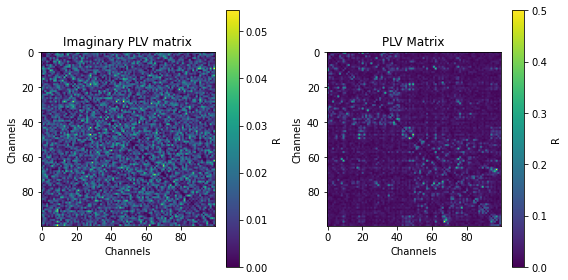

In [5]:
# YOUR CODE HERE
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# iPLV
iplv = ax1.imshow(iplv_mat)
ax1.set_title('Imaginary PLV matrix')
plt.colorbar(iplv, ax=ax1, label = 'R')
ax1.set_xlabel('Channels')
ax1.set_ylabel('Channels')

# PLV
plv = ax2.imshow(plv_mat)
ax2.set_title('PLV Matrix')
plt.colorbar(plv, ax=ax2, label = 'R')
ax2.set_xlabel('Channels')
ax2.set_ylabel('Channels')

plt.tight_layout()
plt.show()

### Going for the surrogates

You should now see some structure in the iPLV and PLV plots, although they represent different aspects and their values differ significantly. Reflect on the reasons for these differences (refer to Lecture 8). However, examining these plots alone isn't particularly informative; we need to determine what is significant and what is not. Let's explore a basic example that demonstrates a way to construct a surrogate for assessing significance across multiple frequencies simultaneously. In practice, this process would be more complex, and ideally, the surrogate would be initialized in the sensor space to account for source modeling effects. However, this simplified approach is sufficient for the course's purposes and reduces computational load considerably.

Essentially, you need to obtain a surrogate that answers: how likely are we to observe these effects based on randomness alone? Since PLV and iPLV are pairwise metrics, we can create the surrogate by completely breaking the pairwise structure of the data. Ideally this surrogate creation would be performed 1,000 times.


To construct the surrogate, you will need the following functions:

- [`numpy.roll`](https://numpy.org/doc/stable/reference/generated/numpy.roll.html)
- [`numpy.random.randint`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

First, create a loop that iterates through all the channels and applies the `numpy.roll` function to randomly shift the time series of each channel. This process breaks the pairwise structure. In other words, initially, for channel N and channel M, the samples at each frequency F are matched. After applying the random rolling, the samples become completely unmatched, as the time series for each channel is shifted by a random amount. The amount of rolling should be a random integer between 0 and `n_samples`. Remember to set the `axis` parameter to `-1` when using the `numpy.roll` function.


In [6]:
cwtm_surr = analytical_signal.copy()

# YOUR CODE HERE
print(cwtm_surr.shape)
for i in range(cwtm_surr.shape[1]):
    shift = np.random.randint(cwtm_surr.shape[3])
    cwtm_surr[0,i] = np.roll(cwtm_surr[0, i], shift, axis = -1)

(1, 100, 10, 45000)


Now that we have the surrogate dataset, proceed with the following steps:

1. Take the `cwtm` and the `surrogate`.
2. Reshape both datasets so that, instead of continuous time, you have 5-second epochs.
3. For each frequency and epoch, compute the complex PLV (do not take the absolute value immediately).
4. Compute `PLV_data - PLV_surr` and `iPLV_data - iPLV_surr` for each frequency and epoch.

So, as an output, you will have the iPLV and PLV results for each frequency and for each epoch. It might not be immediately clear why we did these 'pseudoepochs' but it will be imminent soon.


In [7]:
from tqdm.notebook import tqdm

# YOUR CODE HERE
# Taking data and surrogate data
cwtm = analytical_signal
cwtm_surr = cwtm_surr
n_epochs, n_channels, n_freqs, n_times = 1, 100, 10, 45000
epoch_size = 5 * sampling_rate
n_epochs = n_times // epoch_size
# Reshaping datasets
epochs = cwtm.reshape(n_channels, n_freqs, n_epochs, epoch_size)
epochs_surr = cwtm_surr.reshape(n_channels, n_freqs, n_epochs, epoch_size)
print(epochs.shape)
print(epochs_surr.shape)

# Function that calculates complex PLV
def compute_plv(epochs_data, epochs_surr):
    plv_data = np.abs(np.mean(np.exp(1j * np.angle(epochs_data)), axis=0))
    plv_surr = np.abs(np.mean(np.exp(1j * np.angle(epochs_surr)), axis=0))
    
    iplv_data = np.abs(np.mean(np.exp(1j * np.angle(epochs_data)), axis=0).imag)
    iplv_surr = np.abs(np.mean(np.exp(1j * np.angle(epochs_surr)), axis=0).imag)
  
    plv_diff = np.abs(plv_data - plv_surr)
    iplv_diff = np.abs(iplv_data - iplv_surr)

    return plv_diff, iplv_diff

    
plv_diff = compute_plv(epochs, epochs_surr)
iplv_diff = compute_plv(epochs, epochs_surr)
plv_diff = np.array(plv_diff)
iplv_diff = np.array(iplv_diff)
print(plv_diff.shape)
print(iplv_diff.shape)

(100, 10, 36, 1250)
(100, 10, 36, 1250)
(2, 10, 36, 1250)
(2, 10, 36, 1250)


### Wilcoxon test

We have now created a single surrogate, morphed our data into epochs, and computed the difference `iPLV_data - iPLV_surr` for all frequencies and all epochs. It is important to remember that any R-like metric is positively biased by the number of trials and follows a Rayleigh distribution at the null level. This makes parametric statistics (such as t-tests) unsuitable for our analysis. Instead, we can use a non-parametric statistical test like the Wilcoxon signed-rank test. To perform this test, we need the epochs. The difference in each epoch for a specific frequency `F` counts as a data point that is ranked. 

Below is a link to the `wilcoxon` function you can use. To conveniently test across all frequencies simultaneously without needing to manipulate the array, set the `zero_method` parameter to `'zsplit'`. Otherwise, it will produce an error due to the zeroes on the diagonal. Furthermore, set the parameter `alternative` to `'greater'`. Loop through all frequencies separately.

__Useful Functions:__

- [Wilcoxon Signed-Rank Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)


In [8]:
from scipy.stats import wilcoxon

zero_method = 'zsplit'
alternative = 'greater'

# YOUR CODE HERE
for i in tqdm(np.arange(n_freqs)):
    res = wilcoxon(plv_diff[:,i,:,:], zero_method = zero_method, alternative = alternative)
    ires = wilcoxon(iplv_diff[:,i,:,:], zero_method = zero_method, alternative = alternative)
print(res.pvalue)
print(ires.pvalue)

  0%|          | 0/10 [00:00<?, ?it/s]

[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]
[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]


In [ ]:
#Dont know why my pvalues are same. Maybe smth in calculations

### Plot the heatmaps

Now, let's create a similar iPLV and PLV subplot heatmap as before from the not-epoched `cplv`. This time, however, use the obtained p-values for iPLV and PLV to mask all elements that are not significant at `alpha = 0.05`. This will help you visualize only the significant connections in the brain networks.

In [23]:
# YOUR CODE HERE
import numpy.ma as ma
res = np.array(res)
ires = np.array(ires)
print(res.shape)
print(ires.shape)

alpha = 0.05
plv_mask = ma.masked_where(res > alpha, plv_diff)
iplv_mask = ma.masked_where(ires > alpha, iplv_diff)

# Plot the heatmaps
fig, ax = plt.subplots(1,2, figsize=(10, 5))

plv_im = ax[0].imshow(plv_mask)
ax[0].set_title('PLV Difference')
fig.colorbar(plv_im, ax=ax[0])

iplv_im = ax[1].imshow(iplv_mask)
ax[1].set_title('iPLV Difference')
fig.colorbar(iplv_im, ax=ax[1])

plt.show()

(2, 36, 1250)
(2, 36, 1250)


IndexError: Inconsistent shape between the condition and the input (got (2, 36, 1250) and (2, 10, 36, 1250))

### Converting p-values

Next up, take the iPLV and PLV p_values, set all p-values less than 0.05 to 1 and everything else to 0. Then, take the mean two times across the parcel dimensions to get 'fraction of significants' for each frequency.

In [42]:
# YOUR CODE HERE
p_iplv[p_iplv < 0.05] = 1
p_iplv[p_iplv != 1] = 0
p_plv[p_plv < 0.05] = 1
p_plv[p_plv != 1] = 0
# Fraction of significants (fos)
fos_iplv = np.mean(np.mean(p_iplv, axis=1), axis=1)
fos_plv = np.mean(np.mean(p_plv, axis=1), axis=1)

### Visualizing the Fraction of Significant Connections

Finally, create a plot that displays the fraction of significant connections for both iPLV and PLV results. 

To create a clear and informative plot, consider the following formatting guidelines:

1. Use different colors for iPLV and PLV fraction of significants.
2. Add a legend to distinguish between the two.
3. Include a title, axis labels, and other necessary annotations.
4. Add a vertical line at zero to provide a reference point.
5. Add a vertical line at 0.05 to indicate the significance threshold.


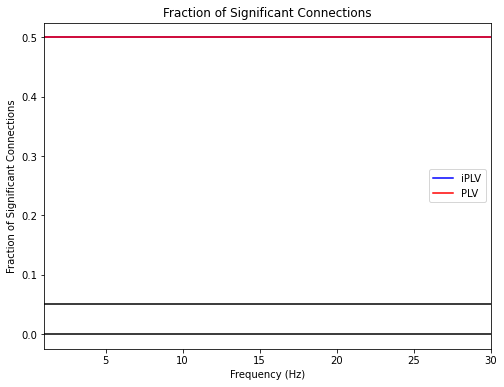

In [43]:
# YOUR CODE HERE
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(freqs, fos_iplv, label = 'iPLV', color = 'blue')
ax.plot(freqs, fos_plv, label = 'PLV', color = 'red')
ax.set_title('Fraction of Significant Connections')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Fraction of Significant Connections')
ax.legend()
ax.axhline(y = 0, color = 'black')
ax.axhline(y = 0.05, color = 'black')
ax.set_xlim(freqs[0], freqs[-1])
plt.show()

The two results should share resemblance but still be different. Look at the values on the co

# Quarterly Exam 4

## Literature task (8 points)
Use a maximum of 2 hours to investigate literature and grasp what you can. Disclaimer: GP literature is notoriously difficult for even the professionals in the field, so don’t be intimidated.

Heterogeneities in complex systems have a potential to stretch the critical point in their state space into a wider state regime between sub- and supercritical phases where critical-like dynamics may be observed. This regime is also known as the Griffiths phase (GP). Find three scientific articles about GP and summarize their findings, main claims, and justifications for said claims in an essay of no more than one page.


## Extrapolative Essay (12 points)
Use a maximum of 3 hours for reflection and writing the essay. Aim at a max. one A4 page for the whole essay (less is fine, exceeding one page will not be punished).

(4 points) Consider which factors in the human brains may predispose them containing a GP in their state space and operating in it. 

(8 points) Reflect on the insight you have gained over the present course and predict the functional consequences of human brains operating in GP as opposed to operating at a critical point.
